In [1]:
import rospy
import time
import jupyros as jr
import matplotlib
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import math
import actionlib
import actionlib.msg
from matplotlib.animation import FuncAnimation

%matplotlib notebook

from std_srvs.srv import *
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist
from assignment_2_2022.msg import Posxy_velxy
from colorama import Fore, Style
from colorama import init
from IPython.display import display


init()

In [2]:
# Initialize the ROS node

rospy.init_node('node_a_action_client')

In [3]:
#Then, we need to define some variables to keep track of the robot's position and the targets:

robot_position = None
target_positions = []
cancelled_target_positions = []
closest_obstacle_distance = None


In [4]:
#We also need to define a callback function for the Odometry subscriber that updates the robot's position:

def odometry_callback(msg):
    global robot_position
    robot_position = (msg.pose.pose.position.x, msg.pose.pose.position.y)


In [5]:
#Next, we can define a function that creates a new target and adds it to the list of target positions:

def create_target(x, y):
    target_positions.append((x, y))

In [6]:
#Define a function that cancels a target and removes it from the list of target positions:

def cancel_target(x, y):
    for target in target_positions:
        if target[0] == x and target[1] == y:
            target_positions.remove(target)
            cancelled_target_positions.append(target)


BoundedFloatText(value=0.0, description='X:', max=10.0, min=-10.0, step=0.1)

BoundedFloatText(value=0.0, description='Y:', max=10.0, min=-10.0, step=0.1)

Button(description='Create Target', style=ButtonStyle(button_color='green'))

Button(description='Cancel Last Target', style=ButtonStyle(button_color='red'))

<IPython.core.display.Javascript object>


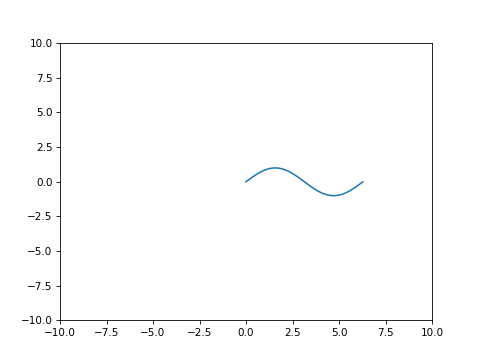

Textarea(value='Closest Obstacle Distance:', disabled=True, layout=Layout(width='auto'), placeholder='')

In [7]:
#Now, we can define the GUI using ipywidgets. We will create a text box for the user to input 
#the target position, a button to create the target, a button to cancel the last target, and a plot 
#to display the laser scanner info.

x_text = widgets.BoundedFloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='X:',
    disabled=False
)

y_text = widgets.BoundedFloatText(
    value=0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Y:',
    disabled=False
)

create_button = widgets.Button(description="Create Target", style={'button_color': 'green'})
cancel_button = widgets.Button(description="Cancel Last Target", style={'button_color': 'red'})

display(x_text)
display(y_text)
display(create_button)
display(cancel_button)

fig, ax = plt.subplots()
plt.xlim([-10, 10])
plt.ylim([-10, 10])
line, = ax.plot([], [])

def calculate_closest_obstacle_distance(robot_position):    
    obstacle_position = (2, 2)
    distance = math.sqrt((robot_position[0] - obstacle_position[0]) ** 2 + (robot_position[1] - obstacle_position[1]) ** 2)
    return distance


def plot_laser_scanner(robot_position):
    xs = np.linspace(0, 2*math.pi, 100)
    ys = np.sin(xs)
    line.set_xdata(xs)
    line.set_ydata(ys)
    
    # Calculate closest obstacle distance
    closest_obstacle_distance = calculate_closest_obstacle_distance(robot_position)
    
    # Update the closest_obstacle_distance text box
    distance_text.value = f"Closest Obstacle Distance: {closest_obstacle_distance:.2f}"
    
    fig.canvas.draw()

# Create a text box widget to display the closest obstacle distance:
distance_text = widgets.Textarea(
    value="Closest Obstacle Distance:",
    placeholder='',
    description='',
    layout={'width': 'auto'},
    disabled=True
)
display(distance_text)
    

def create_target_button_clicked(_):
    create_target(x_text.value, y_text.value)
    update_target_status_plot()
    
def cancel_target_button_clicked(_):
    if len(target_positions) > 0:
        cancel_target(*target_positions[-1])
        update_target_status_plot()

create_button.on_click(create_target_button_clicked)
cancel_button.on_click(cancel_target_button_clicked)

In [8]:
def update_display():
    print("Robot Position:", robot_position)
    print("Target Positions:", target_positions)
    print("Cancelled Target Positions:", cancelled_target_positions)
    print("Closest Obstacle Distance:", closest_obstacle_distance)
    plot_laser_scanner(robot_position)
    update_target_status_plot()

<IPython.core.display.Javascript object>


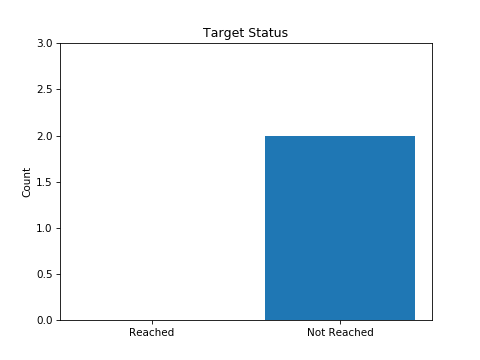

In [9]:
def update_target_status_plot():
    #reached = len(cancelled_target_positions)
    #not_reached = len(target_positions) - reached
    
    reached = len(target_positions) - len(cancelled_target_positions)
    not_reached = len(cancelled_target_positions) 
    labels = ['Reached', 'Not Reached']
    values = [reached, not_reached]

    ax2.clear()
    ax2.bar(labels, values)
    ax2.set_ylabel('Count')
    ax2.set_title('Target Status')
    ax2.set_ylim([0, max(reached, not_reached) + 1])
    fig2.canvas.draw()

fig2, ax2 = plt.subplots()

In [10]:
# Updates the plot at each animation frame
def animate(frame):
    update_display()

animation = FuncAnimation(fig, animate, interval=200)

In [11]:
# It start the animation and display the plot: 
plt.show()

jr.publish('create_target', Posxy_velxy)
jr.publish('cancel_target', Posxy_velxy)